#### Notebook for Exploring Pruning of BERT: Inspired from: https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb#scrollTo=YOCrQwPoIrJG

#### Task selected using Huggingface's Datasets

In [1]:
import torch
import torch.nn.utils.prune as prune
from torch_cka import CKA
import datasets
import transformers
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from bertviz import model_view, head_view

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Task
CoLA outputs a binary label of gramatically correct or not. It was deemed the easiest place to start. 

In [14]:
# Setup chosen task and metric
task = "cola"
checkpoint = "bert-base-uncased"
batch_size = 16
dataset = datasets.load_dataset("glue", task)
metric = datasets.load_metric("glue", task)

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [14]:
#print(dataset)
#print(dataset["train"][0])

print(dataset.with_format("torch"))

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})


In [3]:
print(metric)

# Using metric
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

{'matthews_correlation': 0.047619047619047616}

In [21]:
# Define tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained(checkpoint, use_fast=True)
# Example
print(tokenizer("Hello, this one sentence!", "And this sentence goes with it."))

#print(f"Sentence: {dataset['train'][0]['sentence']}")

# preprocess function
def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True)

preprocess_function(dataset['train'][:5])
encoded_dataset = dataset.map(preprocess_function, batched=True)

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'input_ids': [101, 7592, 1010, 2023, 2028, 6251, 999, 102, 1998, 2023, 6251, 3632, 2007, 2009, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1063
    })
})


In [5]:
# Grab BERT for sequence classification

num_labels = 2
model = transformers.BertForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
metric_name = "matthews_correlation"
model_name = checkpoint.split("/")[-1]

args = transformers.TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [7]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [8]:
validation_key = "validation"
trainer = transformers.Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [91]:
trainer.train()

 19%|█▊        | 498/2675 [00:21<01:37, 22.27it/s]


                                                  

 19%|█▉        | 504/2675 [00:22<01:38, 22.03it/s]

{'loss': 0.4882, 'grad_norm': 12.448992729187012, 'learning_rate': 1.6261682242990654e-05, 'epoch': 0.93}


 20%|█▉        | 534/2675 [00:23<01:34, 22.71it/s]


                                        
                                                  

 20%|██        | 535/2675 [00:23<01:34, 22.71it/s]

{'eval_loss': 0.4358927607536316, 'eval_matthews_correlation': 0.5127103010689016, 'eval_runtime': 0.5811, 'eval_samples_per_second': 1794.867, 'eval_steps_per_second': 113.577, 'epoch': 1.0}


 37%|███▋      | 999/2675 [00:45<01:14, 22.41it/s]


                                                  

 37%|███▋      | 1002/2675 [00:45<01:15, 22.11it/s]

{'loss': 0.2895, 'grad_norm': 8.363648414611816, 'learning_rate': 1.2523364485981309e-05, 'epoch': 1.87}


 40%|███▉      | 1068/2675 [00:48<01:10, 22.90it/s]


                                        
                                                   

 40%|████      | 1070/2675 [00:49<01:10, 22.90it/s]

{'eval_loss': 0.4896464943885803, 'eval_matthews_correlation': 0.544509467622167, 'eval_runtime': 0.5894, 'eval_samples_per_second': 1769.678, 'eval_steps_per_second': 111.983, 'epoch': 2.0}


 56%|█████▌    | 1500/2675 [01:10<00:52, 22.22it/s]


                                                   

 56%|█████▌    | 1503/2675 [01:10<00:53, 21.85it/s]

{'loss': 0.1915, 'grad_norm': 0.3836360275745392, 'learning_rate': 8.785046728971963e-06, 'epoch': 2.8}


 60%|██████    | 1605/2675 [01:15<00:47, 22.44it/s]


                                        
                                                   

 60%|██████    | 1605/2675 [01:16<00:47, 22.44it/s]

{'eval_loss': 0.5909231901168823, 'eval_matthews_correlation': 0.5806473000395166, 'eval_runtime': 0.5812, 'eval_samples_per_second': 1794.563, 'eval_steps_per_second': 113.558, 'epoch': 3.0}


 75%|███████▍  | 2000/2675 [01:36<00:31, 21.65it/s]


                                                   

 75%|███████▍  | 2003/2675 [01:36<00:31, 21.07it/s]

{'loss': 0.1283, 'grad_norm': 9.708556175231934, 'learning_rate': 5.046728971962617e-06, 'epoch': 3.74}


 80%|███████▉  | 2138/2675 [01:43<00:25, 21.38it/s]


                                        
                                                   

 80%|████████  | 2140/2675 [01:43<00:25, 21.38it/s]

{'eval_loss': 0.983931303024292, 'eval_matthews_correlation': 0.5572696682585848, 'eval_runtime': 0.6233, 'eval_samples_per_second': 1673.34, 'eval_steps_per_second': 105.887, 'epoch': 4.0}


 93%|█████████▎| 2498/2675 [02:02<00:08, 21.83it/s]


                                                   

 94%|█████████▎| 2504/2675 [02:02<00:07, 21.44it/s]

{'loss': 0.0786, 'grad_norm': 0.07026872783899307, 'learning_rate': 1.308411214953271e-06, 'epoch': 4.67}


100%|██████████| 2675/2675 [02:10<00:00, 25.44it/s]


                                        
                                                   

100%|██████████| 2675/2675 [02:10<00:00, 25.44it/s]

{'eval_loss': 0.9713311195373535, 'eval_matthews_correlation': 0.57368884664922, 'eval_runtime': 0.5795, 'eval_samples_per_second': 1799.816, 'eval_steps_per_second': 113.891, 'epoch': 5.0}





                                                   

100%|██████████| 2675/2675 [02:13<00:00, 20.09it/s]

{'train_runtime': 133.1197, 'train_samples_per_second': 321.177, 'train_steps_per_second': 20.095, 'train_loss': 0.22554543753650702, 'epoch': 5.0}


TrainOutput(global_step=2675, training_loss=0.22554543753650702, metrics={'train_runtime': 133.1197, 'train_samples_per_second': 321.177, 'train_steps_per_second': 20.095, 'total_flos': 454848611954580.0, 'train_loss': 0.22554543753650702, 'epoch': 5.0})

In [92]:
ret = trainer.evaluate()
print(ret)
print(ret['eval_matthews_correlation'])

100%|██████████| 66/66 [00:00<00:00, 113.16it/s]

{'eval_loss': 0.5909231901168823, 'eval_matthews_correlation': 0.5806473000395166, 'eval_runtime': 0.6084, 'eval_samples_per_second': 1714.414, 'eval_steps_per_second': 108.486, 'epoch': 5.0}
0.5806473000395166


In [93]:
# Save model
trainer.save_model("bert_pruning_model")

In [79]:
#model == trained_model

#for p1, p2 in zip(model.parameters(), trained_model.parameters()):
#    if(p1.data.ne(p2.data).sum() > 0):
#        print('False')
#print('True')

True

In [9]:
# Load model
trained_model = transformers.BertForSequenceClassification.from_pretrained('bert_pruning_model', num_labels=num_labels, output_attentions=True)

In [10]:
# Calculate sparisty of the network
def calcSparsity(model):
    zeros = 0
    elements = 0

    for name, param in model.named_parameters():

        # Layer was pruned if orig exists
        #parsed_name = name.split('_orig')
        # Layer was pruned
        #if(len(parsed_name) == 2 and parsed_name[0] in parameter_names):

        zero_count = torch.sum(param==0.0).item()
        zeros += zero_count

        element_count = param.numel()
        elements += element_count

    if(elements == 0):
        return 0

    return zeros / elements

In [211]:
# Select the parameters that you wish to prune
parameters_to_prune = []
parameter_names = []
for name, module in trained_model.named_modules():

    # Self-Attention
    #if isinstance(module, transformers.models.bert.modeling_bert.BertSelfAttention):
    #    parameters_to_prune.extend([
    #            (module.query, 'weight'),
    #            (module.key, 'weight'),
    #            (module.value, 'weight'),
    #        ])
    #print(name)
    #parameter_names.append(name)
    #parameter_names.extend([name + '.query', name + '.key', name + '.value'])

    # Linear: Includes linear layers in attention head as well
    if isinstance(module, torch.nn.Linear):
        parameters_to_prune.append((module, 'weight'))
        parameter_names.append(name + '.weight')

In [212]:
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.9
)

for module,name in parameters_to_prune:
    prune.remove(module, name)

In [213]:
calcSparsity()

0.7030577077820607

### PyTorch Section for Training, Evaluating, and Testing

In [2]:
# Setup chosen task and metric
task = "cola"
checkpoint = "bert-base-uncased"
batch_size = 16
dataset = datasets.load_dataset("glue", task)
metric = datasets.load_metric("glue", task)
model_directory = 'bert_pruning_model'

# Figure out dataset characteristics
max_len_train = len(max(dataset['train']['sentence'][:]))
max_len_val = len(max(dataset['validation']['sentence'][:]))
max_len_test = len(max(dataset['test']['sentence'][:]))
max_len = max(max_len_train, max_len_val, max_len_test)

# Tokenize Dataset
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
# preprocess function
def preprocess_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', max_length=max_len)
encoded_dataset = dataset.map(preprocess_function, batched=True)

#def collate_fn(batch):
#    input_ids = torch.stack([item['input_ids'] for item in batch])
#    attention_mask = torch.stack([item['attention_mask'] for item in batch])
#    #label = torch.stack([item['label'] for item in batch])
#    token_type_ids = torch.stack([item['token_type_ids'] for item in batch])
#    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}

/tmp/ipykernel_171168/4270742066.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("glue", task)
/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is depreca

In [ ]:
# Setup chosen task and metric
task = "cola"
checkpoint = "bert-base-uncased"
batch_size = 16
dataset = datasets.load_dataset("glue", task)
metric = datasets.load_metric("glue", task)
model_directory = 'bert_pruning_model'

# Tokenize Dataset
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

# preprocess function
def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)

In [20]:
print(encoded_dataset['test'][0])
print(encoded_dataset['test'][7])

{'sentence': 'Bill whistled past the house.', 'label': -1, 'idx': 0, 'input_ids': [101, 3021, 26265, 2627, 1996, 2160, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'sentence': 'The sooner you call, the more carefully I will word the letter.', 'label': -1, 'idx': 7, 'input_ids': [101, 1996, 10076, 2017, 2655, 1010, 1996, 2062, 5362, 1045, 2097, 2773, 1996, 3

In [3]:
# Convert dataset to torch with torch specs
tokenized_dataset = encoded_dataset.with_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])
print(tokenized_dataset)

train_loader = DataLoader(tokenized_dataset['train'], batch_size=32)
val_loader = DataLoader(tokenized_dataset['validation'], batch_size=32)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=32)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1063
    })
})


In [10]:
print(tokenized_dataset['test'][0])

{'input_ids': tensor([  101,  3021, 26265,  2627,  1996,  2160,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [4]:
num_labels=2
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device
#model1 = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels, output_attentions=True)
model1 = transformers.BertForSequenceClassification.from_pretrained(model_directory, num_labels=num_labels, output_attentions=True)
model2 = transformers.BertForSequenceClassification.from_pretrained(model_directory, num_labels=num_labels, output_attentions=True)

model1 = model1.to(device)
model2 = model2.to(device)

In [5]:
"""
def getRelevantLayers(model):
    nameList = []
    for name, layer in model1.named_modules():
        #if("bert.encoder.layer.attention" in name):
        #    nameList.append(name)
        print(name)
    return nameList
"""
#model1_names = getRelevantLayers(model1)
#model2_names = getRelevantLayers(model2)

model1_names = [f"bert.encoder.layer.{i}.attention" for i in range(0, 12)]
model2_names = model1_names

In [17]:
model1_inlayers = []
for name, layer in model1.named_modules():
    if(name in model1_names):
        print(layer)
    #model1_inlayers.append(name)

#print(list(set(model1_names) & set(model1_inlayers)))

BertAttention(
  (self): BertSelfAttention(
    (query): Linear(in_features=768, out_features=768, bias=True)
    (key): Linear(in_features=768, out_features=768, bias=True)
    (value): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (output): BertSelfOutput(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertAttention(
  (self): BertSelfAttention(
    (query): Linear(in_features=768, out_features=768, bias=True)
    (key): Linear(in_features=768, out_features=768, bias=True)
    (value): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (output): BertSelfOutput(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=Fal

In [6]:
cka = CKA(model1, model2, model1_name="Model1", model2_name="Model2", model1_layers=model1_names, model2_layers=model2_names, device=device)
cka.compare(train_loader)
results = cka.export()

| Comparing features |:   0%|          | 0/268 [00:00<?, ?it/s]

| Comparing features |:  12%|█▏        | 32/268 [00:05<00:42,  5.55it/s]


AssertionError: Feature shape mistach! torch.Size([32, 32]), torch.Size([19, 19])

{'model1_name': 'Model1', 'model2_name': 'Model2', 'CKA': tensor([[0.9994, 0.9631, 0.9377, 0.7887, 0.7736, 0.7973, 0.8159, 0.8360, 0.7984,
         0.4938, 0.2498, 0.1473],
        [0.9552, 0.9936, 0.9709, 0.8073, 0.7902, 0.8169, 0.8350, 0.8556, 0.8192,
         0.5099, 0.2580, 0.1519],
        [0.9187, 0.9633, 0.9842, 0.7946, 0.7746, 0.8037, 0.8236, 0.8470, 0.8152,
         0.5135, 0.2608, 0.1546],
        [0.7952, 0.8200, 0.8031, 0.9975, 0.9949, 0.9909, 0.9832, 0.9661, 0.8819,
         0.4771, 0.2120, 0.1194],
        [0.7835, 0.8052, 0.7848, 0.9958, 0.9970, 0.9925, 0.9846, 0.9669, 0.8829,
         0.4774, 0.2123, 0.1196],
        [0.8109, 0.8345, 0.8180, 0.9921, 0.9928, 0.9945, 0.9909, 0.9791, 0.9011,
         0.4984, 0.2267, 0.1290],
        [0.8323, 0.8563, 0.8437, 0.9834, 0.9840, 0.9907, 0.9928, 0.9871, 0.9153,
         0.5163, 0.2393, 0.1374],
        [0.8518, 0.8778, 0.8703, 0.9641, 0.9640, 0.9770, 0.9848, 0.9882, 0.9260,
         0.5360, 0.2546, 0.1477],
        [0.8533, 0.881

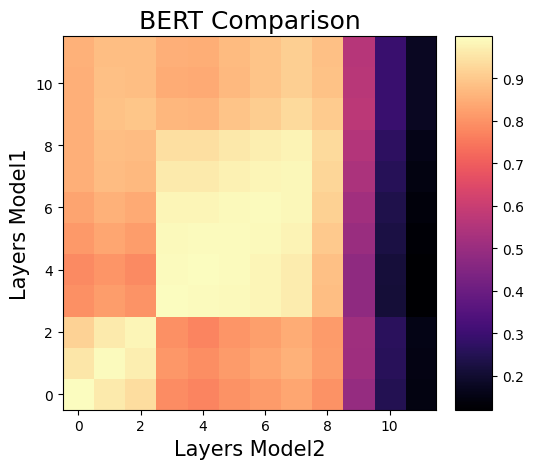

In [20]:
print(results)
cka.plot_results("plot", "BERT Comparison")

In [9]:
# Set test environment
model.eval()
with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        #batch = {k: v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        break

{'input_ids': tensor([[  101,  3021, 26265,  2627,  1996,  2160,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [34]:
#batch = {k: v.to('cpu') for k,v in batch.items()}

# Get tokens from input
ids = batch['input_ids']
tokens = tokenizer.convert_ids_to_tokens(ids[0])

# Get attention masks from output
masks = outputs.attentions

#model_view(masks, tokens)
head_view(masks, tokens)

<IPython.core.display.Javascript object>

In [11]:
### NOTE: All of this code is direct PyTorch. Trying to use huggingface caused the fine tuning to fail when attempting to print out attention masks.
###       We need to convert to PyTorch to do the pruning anyways so it makes sense to simply stay there

metric_name = "matthews_correlation"
metric = datasets.load_metric("glue", task)
models = []

# Note: The pruning strength is for the subset of the neurons that you want to prune (defined by the paramater list created in the build parameter list function #
def buildParameterList(model):
    parameters_to_prune = []
    parameter_names = []
    for name, module in model.named_modules():
        # Linear: Includes linear layers in attention head as well
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    return parameters_to_prune, parameter_names

# NOTE: Metric is defined globally
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # TODO: switch to torch?
    return metric.compute(predictions=predictions, references=labels)

def evaluateUnstructuredPruningOnBert(model_directory, dataset, tokenizer, pruning_strength=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], num_labels=2):

    pruning_results = []

    # Try different pruning methods
    for p_strength in pruning_strength:

        # Load model
        test_model = transformers.BertForSequenceClassification.from_pretrained(model_directory, num_labels=num_labels, output_attentions=True)

        # Choose layers to prune
        pruning_params = buildParameterList(test_model)

        if(p_strength > 0):

            # Perform pruning
            prune.global_unstructured(
                pruning_params,
                pruning_method=prune.L1Unstructured,
                amount=p_strength
            )

            # Make pruning permenant
            for module,name in pruning_params:
                prune.remove(module, name)

        models.append(test_model)

        sparsity = calcSparsity(test_model)
        print(f"Pruning strength: {p_strength}, Sparsity: {sparsity}")

        # Create evaluator
        evaluator = buildTrainer(test_model, dataset, tokenizer)

        # Evaluate performance on BERT 
        results = evaluator.evaluate()
        metric_res = results['eval_matthews_correlation']

        pruning_results.append((sparsity, metric_res))
        
    return pruning_results

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [12]:
model_directory = 'bert_pruning_model'
p_res = evaluateUnstructuredPruningOnBert(model_directory, encoded_dataset, tokenizer)

Pruning strength: 0, Sparsity: 0.0
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


  0%|          | 0/66 [00:00<?, ?it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 19 but got size 17 for tensor number 1 in the list.

In [230]:
print(p_res)

[(0.0, 0.5932805322494611), (0.0781175271463504, 0.5779181076197502), (0.15623504515892755, 0.559827888599451), (0.23435257230527795, 0.5337975510473064), (0.3124700903178551, 0.5179391870486293), (0.3905876174642055, 0.37130794726495275), (0.4687051446105559, 0.07583845140032916), (0.5468226626231331, 0.018148342420931135), (0.6249401897694835, 0.004186223773740697), (0.7030577077820607, -0.03534585767137743)]


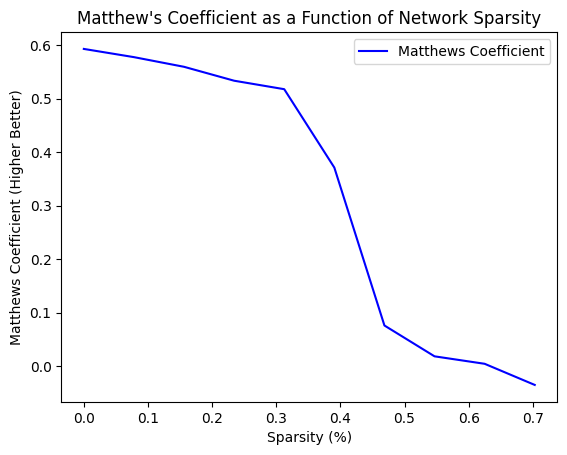

In [231]:
# Plot results
sparsities = []
metric_results = []

for sparsity, met in p_res:
    sparsities.append(sparsity)
    metric_results.append(met)

plt.plot(sparsities, metric_results, label="Matthews Coefficient", color="blue")
plt.title("Matthew's Coefficient as a Function of Network Sparsity")
plt.xlabel("Sparsity (%)")
plt.ylabel("Matthews Coefficient (Higher Better)")
plt.legend()
plt.show();

#### EXTRA CODE THAT DIDN'T GET USED ####

In [19]:
# Override BertTrainer class to specify custom functionality
class BertTrainer(transformers.Trainer):
    # Overrides Trainer prediction so that attention maps can be output as well
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        # Move inputs to device
        inputs = self._prepare_inputs(inputs)

        # Forward pass (prediction)
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        attentions = outputs[2]

        attentions = torch.stack(list(attentions), dim=0)

        print(type(loss), type(logits), type(attentions))

        return (loss, logits, attentions) if not prediction_loss_only else (loss, None, None)

    #def evaluate(self, eval_dataset, ignore_keys, metric_key_prefix = 'eval', **gen_kwargs):

def buildTrainer(model, encoded_dataset, tokenizer):

    args = transformers.TrainingArguments(
        f"{model_name}-finetuned-{task}-Testing",
        per_device_eval_batch_size=batch_size,
        metric_for_best_model=metric_name,
        push_to_hub=False,
    )

    evaluator = BertTrainer(
        model,
        args,
        eval_dataset=encoded_dataset['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    return evaluator